In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime

In [2]:
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt'
df = pd.read_csv(url, header = 0, sep=',')
df.columns = map(str.lower, df.columns) # - make headers lowercase
df.columns = df.columns.str.strip().str.lower()

In [25]:
df.head(5)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,exit_increments,entry_increments,previous_entry_number,previous_datetime,time_block
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,00:00:00,REGULAR,7089463,2401758,2019-06-08 00:00:00,-1,-1,-1,1980-01-01 00:00:00,-1.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,04:00:00,REGULAR,7089491,2401764,2019-06-08 04:00:00,6,28,7089463,2019-06-08 00:00:00,1.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,08:00:00,REGULAR,7089511,2401807,2019-06-08 08:00:00,43,20,7089491,2019-06-08 04:00:00,2.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,12:00:00,REGULAR,7089598,2401889,2019-06-08 12:00:00,82,87,7089511,2019-06-08 08:00:00,3.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,16:00:00,REGULAR,7089801,2401946,2019-06-08 16:00:00,57,203,7089598,2019-06-08 12:00:00,4.0


In [28]:
df['ttime'] = pd.to_datetime(df['time'])
df['tdate'] = pd.to_datetime(df['date'])
df['datetime'] = df.apply (lambda x: datetime.datetime (x['tdate'].year, x['tdate'].month, x['tdate'].day,
                                                       x['ttime'].hour), axis=1)
df.drop (['ttime','tdate'], inplace=True, axis=1)
df['exit_increments'] = df['exits']
df['entry_increments'] = df['entries']
df['previous_entry_number'] = df['entries']
df['time_block'] = df['entries']
df['previous_datetime'] = df['datetime']

In [5]:
print (df)

          c/a  unit       scp        station linename division        date  \
0        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/08/2019   
1        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/08/2019   
2        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/08/2019   
3        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/08/2019   
4        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/08/2019   
5        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/08/2019   
6        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/09/2019   
7        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/09/2019   
8        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/09/2019   
9        A002  R051  02-00-00          59 ST  NQR456W      BMT  06/09/2019   
10       A002  R051  02-00-00          59 ST  NQR456W      BMT  06/09/2019   
11       A002  R051  02-00-00          59 ST  NQR456W      BMT  

In [65]:
#This creates the dataframe that will be used to store entries for a given station/control area pair for hours
#of the day
tuple1 = ('59 ST', 'A002', 1)

#Convert a tuple into a string for indexing purposes. This is an unfortunate kludge that was necessary due to having
#trouble using a tuple as an index
def string_from_tuple (tup):
    return tup[0]+','+tup[1]+','+str(tup[2])

summary_data = pd.DataFrame(
    data={'c_a_station_time_block': [tuple1],
          'c_a_station': [('59 ST', 'A002')],
          'time_block': [1],
          'entries': [0]},
    index=[string_from_tuple (tuple1)],
    columns=['c_a_station_time_block', 'c_a_station', 'time_block', 'entries'])

#Tabulate the number of entries over a particular four hour block at a particular station/control area pair
def tabulate_entries (ix, data_frame):
    station = data_frame.at [ix, 'station']
    control_area = data_frame.at [ix, 'c/a']
    time_block = data_frame.at [ix, 'time_block']
    entries = data_frame.at [ix, 'entry_increments']
    c_a_station = (station, control_area)
    c_a_station_time_block = (station, control_area, time_block)
    summary_index = string_from_tuple (c_a_station_time_block)
    try:
        existing_entries = summary_data.at [summary_index, 'entries']
        summary_data.at [summary_index, 'entries'] = entries + existing_entries
    except KeyError:
        summary_data.loc [summary_index] = [c_a_station_time_block, c_a_station, time_block, entries]

#Converts a datetime to an integer code representing the four hour block in the week, because
#MTA generally uses four hour intervals. 12am-2am Saturday = 0, 2am-6am Saturday = 1, and so on up to
#6pm-10pm Friday = 41, 10pm-midnight Friday = 42
def convert_datetime_to_four_hour_block (dt):
    day_of_week = dt.weekday()
    day_of_week += 2
    if day_of_week >= 7:
        day_of_week -= 7
    hour = round((dt.hour+.01)/4)
    result = int((6*day_of_week) + hour)
    return result

def max_minus_min_exits (x):
    first_iteration = True
    previous_exits = 0
    for index, row in x.iteritems():
        if first_iteration:
            first_iteration = False
            previous_exits = row
            df.at [index, 'exit_increments'] = -1
        else:
            df.at [index, 'exit_increments'] = row - previous_exits
            previous_exits = row
    result = x.max()-x.min()
    return result
    
def max_minus_min_entries (x):
    first_iteration = True
    previous_entries = 0
    previous_datetime = datetime.datetime (1980,1,1)
    for index, row in x.iteritems():
        if first_iteration:
            first_iteration = False
            previous_entries = row
            df.at [index, 'previous_datetime'] = previous_datetime
            previous_datetime = df.at [index, 'datetime']
            df.at [index, 'entry_increments'] = -1
            df.at [index, 'previous_entry_number'] = -1
            df.at [index, 'time_block'] = -1
        else:
            df.at [index, 'previous_datetime'] = previous_datetime
            previous_datetime = df.at [index, 'datetime']
            entry_count = row - previous_entries
            df.at [index, 'entry_increments'] = entry_count
            df.at [index, 'previous_entry_number'] = previous_entries
            df.at [index, 'time_block'] = convert_datetime_to_four_hour_block (previous_datetime)
            if (entry_count >0) and (entry_count < 5000):
                tabulate_entries (index, df)
            previous_entries = row
    result = x.max()-x.min()
    return result
    
dfgb_exit_group = df.groupby (['station', 'c/a', 'unit', 'scp']) ['exits'].apply (max_minus_min_exits)
dfgb_entry_group = df.groupby (['station', 'c/a', 'unit', 'scp']) ['entries'].apply (max_minus_min_entries)
dfgb2 = dfgb_exit_group.groupby ('station')
dfgb3 = dfgb2.apply (lambda x:x.sum())
dfgb4 = dfgb3.sort_values (0, False)
#print (dfgb4)
#print (dfgb4.sum())
#print(len(dfgb4))
dfgb4.tail(360).sum()
dfgb=dfgb_exit_group.sort_values (0, False)
print (dfgb.sum())
print (len(dfgb))
print (dfgb)
dfgb.tail(4875).sum()

1935980727
4876
station          c/a    unit  scp     
167 ST           N207   R104  00-00-00    1821597417
59 ST            C021   R212  00-00-03      14611973
42 ST-PORT AUTH  N062A  R010  00-06-01       4576563
23 ST            N077   R111  02-06-02       3130109
CHRISTOPHER ST   PTH09  R548  00-00-02       2928014
EXCHANGE PLACE   PTH05  R543  00-00-07       2846786
THIRTY ST        PTH13  R541  00-04-05       2844815
PAVONIA/NEWPORT  PTH06  R546  00-00-05       2611206
THIRTY THIRD ST  PTH17  R541  01-00-05       2221453
TWENTY THIRD ST  PTH12  R542  00-04-00       2111768
PAVONIA/NEWPORT  PTH06  R546  00-00-06       2012831
EXCHANGE PLACE   PTH05  R543  00-00-06       1911541
PAVONIA/NEWPORT  PTH06  R546  00-00-08       1878563
174-175 STS      N212   R253  01-00-01       1789843
THIRTY THIRD ST  PTH17  R541  01-00-02       1783205
                              01-00-09       1591311
EXCHANGE PLACE   PTH05  R543  00-00-04       1349652
LACKAWANNA       PTH16  R550  01-02-00      

114383310

c_a_station
(GRD CNTRL-42 ST, R238A)    354539
(PATH NEW WTC, PTH22)       315936
(34 ST-PENN STA, R138)      264274
(FLUSHING-MAIN, R533)       259547
(JKSN HT-ROOSVLT, N324)     243134
(59 ST COLUMBUS, N051)      228060
(14 ST-UNION SQ, R221)      196938
(34 ST-HERALD SQ, N506)     195133
(34 ST-HERALD SQ, A025)     175113
(GRD CNTRL-42 ST, R240)     172454
(86 ST, R250)               170492
(47-50 STS ROCK, N500)      169535
(W 4 ST-WASH SQ, N083)      167747
(JOURNAL SQUARE, PTH03)     164605
(BEDFORD AV, H009)          156725
(GRAND ST, N520)            154339
(TIMES SQ-42 ST, R151)      154060
(42 ST-PORT AUTH, N063A)    151202
(34 ST-PENN STA, N067)      148940
(125 ST, R258)              148737
(8 AV, H001)                147506
(LEXINGTON AV/53, N306)     147443
(96 ST, R169)               146079
(34 ST-PENN STA, N072)      145779
(THIRTY THIRD ST, PTH17)    143208
(JAY ST-METROTEC, N103)     141132
(14 ST-UNION SQ, A033)      139927
(GRD CNTRL-42 ST, R236)     139826
(42 ST-P

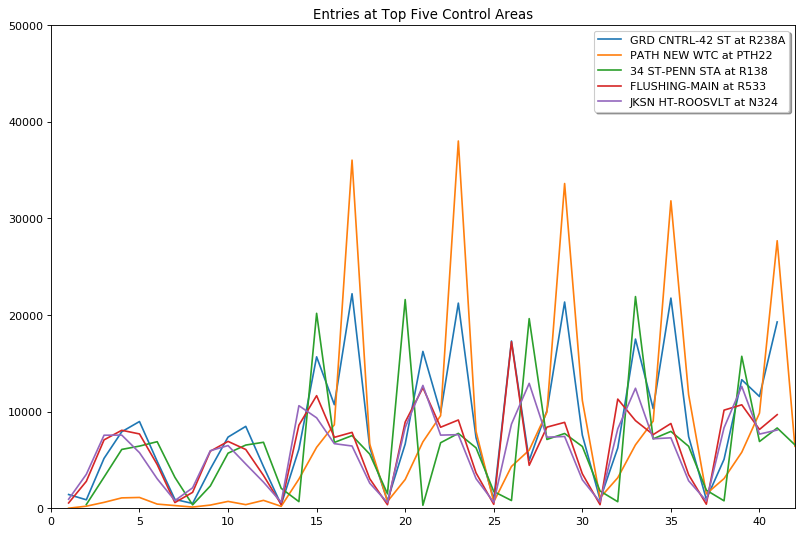

In [104]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

legends = []

# This function reorders a sequence of x values that may not be in the right order for plotting
# For now this is not implemented in a very efficient way
# This function takes as a parameter a station and control area pair
def do_plotting (station, control_area):
    xsa = []
    ysa = []
    entry_data = summary_data.loc[summary_data['c_a_station'] == (station, control_area)]

    xs = entry_data ['time_block']
    ys = entry_data ['entries']
    
    for i in range (0, 43):
        for j in range (0, len(xs)):
            if (xs[j] == i):
                xsa.append (i)
                ysa.append (ys[j])
    plt.plot (xsa, ysa)
    legends.append (station + ' at ' + control_area)


summary_data_sums = summary_data.groupby (['c_a_station']) ['entries'].apply (lambda x:x.sum())
#print (summary_data_sums)
print (summary_data_sums.sort_values(ascending=False))

legends = []

plt.savefig('top_five_control_areas.png', bbox_inches='tight')

do_plotting ('GRD CNTRL-42 ST', 'R238A')
do_plotting ('PATH NEW WTC', 'PTH22')
do_plotting ('34 ST-PENN STA', 'R138')
do_plotting ('FLUSHING-MAIN', 'R533')
do_plotting ('JKSN HT-ROOSVLT', 'N324')
plt.legend (legends, shadow = True, loc = 0);
plt.title('Entries at Top Five Control Areas')
plt.axis ([0,42,0,50000])
#plt.show()

plt.savefig('top_five_control_areas.png')
print('succeeded')


In [72]:
df2=df.drop(['linename','date','time','exits','division','desc'], axis=1)
print (len(df2.index))
df2=df2.drop(df2[df2.entry_increments < 1].index)
df2=df2.drop(df2[df2.station != 'GRD CNTRL-42 ST'].index)
print(df2)
df2.to_csv('/Users/skydivedavis/Documents/gct2.csv')

204934
          c/a  unit       scp          station  entries            datetime  \
157567   R236  R045  00-00-00  GRD CNTRL-42 ST  2022541 2019-06-08 09:00:00   
157568   R236  R045  00-00-00  GRD CNTRL-42 ST  2022671 2019-06-08 13:00:00   
157569   R236  R045  00-00-00  GRD CNTRL-42 ST  2022906 2019-06-08 17:00:00   
157570   R236  R045  00-00-00  GRD CNTRL-42 ST  2023080 2019-06-08 21:00:00   
157571   R236  R045  00-00-00  GRD CNTRL-42 ST  2023147 2019-06-09 05:00:00   
157572   R236  R045  00-00-00  GRD CNTRL-42 ST  2023167 2019-06-09 09:00:00   
157573   R236  R045  00-00-00  GRD CNTRL-42 ST  2023201 2019-06-09 13:00:00   
157574   R236  R045  00-00-00  GRD CNTRL-42 ST  2023308 2019-06-09 17:00:00   
157575   R236  R045  00-00-00  GRD CNTRL-42 ST  2023426 2019-06-09 21:00:00   
157576   R236  R045  00-00-00  GRD CNTRL-42 ST  2023467 2019-06-10 01:00:00   
157578   R236  R045  00-00-00  GRD CNTRL-42 ST  2023531 2019-06-10 09:00:00   
157579   R236  R045  00-00-00  GRD CNTRL-42 S

In [65]:
print(df2)
df2.to_csv('/Users/skydivedavis/Documents/gct.csv')

          c/a  unit       scp          station    entries            datetime  \
157648   R236  R045  00-00-02  GRD CNTRL-42 ST   10486054 2019-06-08 05:00:00   
157595   R236  R045  00-00-00  GRD CNTRL-42 ST    2029998 2019-06-13 05:00:00   
157746   R236  R045  00-00-04  GRD CNTRL-42 ST   12360879 2019-06-11 01:00:00   
158738   R238  R046  00-00-04  GRD CNTRL-42 ST     897296 2019-06-14 04:00:00   
157677   R236  R045  00-00-02  GRD CNTRL-42 ST   10491650 2019-06-13 05:00:00   
157659   R236  R045  00-00-02  GRD CNTRL-42 ST   10486547 2019-06-10 05:00:00   
157718   R236  R045  00-00-03  GRD CNTRL-42 ST    4008277 2019-06-13 05:00:00   
159082   R238  R046  00-05-00  GRD CNTRL-42 ST   34211474 2019-06-08 12:00:00   
159080   R238  R046  00-05-00  GRD CNTRL-42 ST   34211473 2019-06-08 04:00:00   
158919   R238  R046  00-03-01  GRD CNTRL-42 ST   21079908 2019-06-09 08:00:00   
158534   R238  R046  00-00-00  GRD CNTRL-42 ST      85724 2019-06-08 04:00:00   
158284   R237  R046  01-00-0

In [60]:
tuple1 = ('59 ST', 'A002', 1)

def string_from_tuple (tup):
    return tup[0]+','+tup[1]+','+str(tup[2])

summary_data = pd.DataFrame(
    data={'c_a_station_time_block': [tuple1],
          'c_a_station': [('59 ST', 'A002')],
          'time_block': [1],
          'entries': [7]},
    index=[string_from_tuple (tuple1)],
    columns=['c_a_station_time_block', 'c_a_station', 'time_block', 'entries'])

print (summary_data)

print (summary_data.loc [string_from_tuple (tuple1)])

summary_data.loc [string_from_tuple (('59 ST', 'A002', 2))] = [('59 ST', 'A002', 2), ('59 ST', 'A002'), 2, 5]
print (summary_data)

             c_a_station_time_block    c_a_station  time_block  entries
59 ST,A002,1       (59 ST, A002, 1)  (59 ST, A002)           1        7
c_a_station_time_block    (59 ST, A002, 1)
c_a_station                  (59 ST, A002)
time_block                               1
entries                                  7
Name: 59 ST,A002,1, dtype: object
             c_a_station_time_block    c_a_station  time_block  entries
59 ST,A002,1       (59 ST, A002, 1)  (59 ST, A002)           1        7
59 ST,A002,2       (59 ST, A002, 2)  (59 ST, A002)           2        5
